# Python toolkit for fluorescence data processing

Author: Yongmin Hu (yongmin.hu@eawag.ch, yongminhu@outlook.com)

Last update: 2021-03-07

Before running the toolkit, please go through checklist_fluorescence_python_toolkit.doc.

If you change the input in any of the section, please re-run all sections after.

# 0. Import packages

In [1]:
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import ipywidgets
from datetime import datetime, timedelta
from EEMprocessing import *

from ipywidgets import interact, interactive, interact_manual
from ipywidgets import Layout, Button, Dropdown, Label, FloatText, Text, IntSlider, Checkbox, Box
from IPython.display import display, clear_output
from traitlets import traitlets

matplotlib.rcParams['figure.dpi'] = 80
%matplotlib notebook

-------------------------------------------
# 1. Specify data directory and filename format

In [7]:
# read all filenames in the target directory
#filedir_default = '../../../_data/_greywater/2021-03-01-regrowth' # Just the default, could be changed 
filedir_default = './sample_data'

# select all .dat files in the specified directory

dir_selection =ipywidgets.Text(
                               value = filedir_default,
                               description = 'File directory',
                               layout=Layout(width='50%')
                               )
ts_read_from_filename = ipywidgets.Checkbox(
                                            value = True,
                                            description = 'Do you want to read timestamps from filenames?',
                                            style={'description_width': 'initial'},
                                            layout=Layout(width='50%')
                                            )

ts_format = ipywidgets.Text(
                            value = '%Y-%m-%d-%H-%M',
                            decription = 'Format of time in the filenames',
                            layout=Layout(width='30%')
                            )
ts_start_position = ipywidgets.IntText(
                                        value = 1,
                                        decription = 'The start position of time in the filename (count from zero)',
                                        layout=Layout(width='10%')
                                        )
ts_end_position = ipywidgets.IntText(
                                        value = 16,
                                        decription = 'The start position of time in the filename (count from zero)',
                                        layout=Layout(width='10%')
                                        )

ts_widget = ipywidgets.Box([ts_format, ts_start_position, ts_end_position])
caption0 = ipywidgets.VBox([Label(value='Pleae specify the directory of fluorescence data in the text box below. Example:'),
                           Label(value='../../data/introduction/ (relative path)'),
                           Label(value='OR'),
                           Label(value='C:/Users/Alice/MasterThesis/data/introduction (absolute path)'),
                           Label(value='The directory would change automatically after entering new path.')])
caption1 = ipywidgets.Label(value='If you want to read the timestamps from the filename, please specify the time format, start and end posistions of time in the filename:')
caption2 = ipywidgets.Label(value='Time format reference: https://strftime.org/')
caption3 = ipywidgets.VBox([Label(value='Example: "2020-12-02-22-00-00_R2PEM.dat"'),
                           Label(value='Time format = %Y-%m-%d-%H-%M-%S'),
                           Label(value='start position = 1'),
                           Label(value='end position = 19')])
display(caption0, dir_selection, caption1, ts_read_from_filename, ts_widget, caption2, caption3)



Text(value='./sample_data', description='File directory', layout=Layout(width='50%'))

Label(value='If you want to read the timestamps from the filename, please specify the time format, start and e…

Checkbox(value=True, description='Do you want to read timestamps from filenames?', layout=Layout(width='50%'),…

Box(children=(Text(value='%Y-%m-%d-%H-%M', layout=Layout(width='30%')), IntText(value=1, layout=Layout(width='…

Label(value='Time format reference: https://strftime.org/')

-----------------------------------------
# 2. Data preview and parameter selection

In [8]:
%matplotlib inline

# Visualization with interaction
datdir = dir_selection.value
filelist = os.listdir(datdir)
datlist = [file for file in filelist if 'PEM.dat' in file]
data_index = []
if ts_read_from_filename.value:
    tslist = [get_TS_from_filename(file, ts_format=ts_format.value, ts_start_position=ts_start_position.value-1,
                                  ts_end_position=ts_end_position.value) for file in datlist]
    tslist_sortidx = np.argsort(tslist)
    tslist_sorted = [tslist[i] for i in tslist_sortidx]
    datlist = [datlist[i] for i in tslist_sortidx]
else:
    data_index = [file[:-4] for file in datlist]

# --------------Create widgets for plotting parameters-------------

#---------Tab1: plotting and processing step selection-------
autoscale = ipywidgets.Checkbox(value = False,
                                description='Autoscale')
inner_filter_effect = ipywidgets.Checkbox(value=True, description='Inner filter effect')
scattering_correction = ipywidgets.Checkbox(value=True,
                                            description='Scattering correction')
contour_mask = ipywidgets.Checkbox(value=False,
                                        description='Contour detection')
gaussian_smoothing = ipywidgets.Checkbox(value=True,
                                        description='Gaussian smoothing')
scattering_interpolation = ipywidgets.Dropdown(options=['zero','linear','linear2'],
                                               description='Scattering interpolation method',
                                              style={'description_width': 'initial'})
crange_cw = ipywidgets.IntRangeSlider(
    value = [0,1000],
    min = -1000,
    max = 20000,
    step = 100,
    description = 'Intensity',
    continuous_update=False,
    style={'description_width': 'initial'})

Em_range_display = ipywidgets.IntRangeSlider(
    value = [250,600],
    min = 200,
    max = 820,
    step = 10,
    description = 'Emission',
    continuous_update=False,
    style={'description_width': 'initial'})

Ex_range_display = ipywidgets.IntRangeSlider(
    value = [250,500],
    min = 200,
    max = 550,
    step = 5,
    description = 'Excitation',
    continuous_update=False,
    style={'description_width': 'initial'})

filedir = ipywidgets.fixed(datdir)

plot_abs = ipywidgets.Checkbox(value=True,
                               description='Plot absorbance')

filename = ipywidgets.Dropdown(options=datlist,
                               description='Filename',
                               style={'description_width': 'initial'},
                              layout={'width':'max-content'})

title = ipywidgets.Checkbox(value=False,
                           description='Figure title (time)')

ABSxmax = ipywidgets.fixed(0.1)

#----------Tab2: Parameter selection----------------

gaussian_sigma = ipywidgets.FloatText(value=1, description='gaussian smoothing sigma',
                                   style={'description_width': 'initial'})
gaussian_truncate = ipywidgets.IntText(value=3, description='gaussian smoothing truncate',
                                      style={'description_width': 'initial'})
contour_otsu = ipywidgets.Checkbox(value=True, description='OTSU automatic thresholding',
                                  style={'description_width': 'initial'})
contour_binary_threshold = ipywidgets.IntText(value=50, description='Mannual thresholding (0-255)',
                                             style={'description_width': 'initial'})
scattering_width = ipywidgets.IntText(value=15, description='Rayleigh scattering width [nm]',
                                     style={'description_width': 'initial'})
ts_format_plot = ipywidgets.fixed(value=ts_format.value)
ts_start_position_plot = ipywidgets.fixed(value=ts_start_position.value-1)
ts_end_position_plot = ipywidgets.fixed(value=ts_end_position.value)

#---------------------------Interface Layout----------------------

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

readdata_items = [
    ipywidgets.Box([filename], layout=form_item_layout),
    ipywidgets.Box([Em_range_display, Ex_range_display, crange_cw], layout=form_item_layout),
#    ipywidgets.Box([scattering_correction, scattering_interpolation],layout=form_item_layout),
    ipywidgets.Box([gaussian_smoothing, inner_filter_effect, scattering_correction],layout=form_item_layout),
    ipywidgets.Box([contour_mask, title, plot_abs],layout=form_item_layout)
]

readdata = Box(readdata_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='100%'
))

parameters_items = [
    ipywidgets.Box([gaussian_sigma, gaussian_truncate]),
    ipywidgets.Box([scattering_width, scattering_interpolation]),
    ipywidgets.Box([contour_otsu, contour_binary_threshold])
]

parameters = Box(parameters_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='100%'
))

tab = ipywidgets.Tab()
tab.children=[readdata, parameters]
tab.set_title(0, 'Read data')
tab.set_title(1, 'Parameters')


out_parameters = ipywidgets.interactive_output(plot3DEEM_interact,
                                    {'filedir':filedir, 'filename':filename, 'autoscale':autoscale,
                                     'crange':crange_cw, 'scattering_correction':scattering_correction, 'inner_filter_effect':inner_filter_effect,
                                     'plot_abs':plot_abs, 'ABSxmax':ABSxmax, 'title':title, 'Em_range_display':Em_range_display,
                                     'Ex_range_display':Ex_range_display, 'contour_mask':contour_mask, 'gaussian_smoothing':gaussian_smoothing,
                                     'scattering_interpolation': scattering_interpolation,'sigma':gaussian_sigma,'truncate':gaussian_truncate,
                                     'otsu':contour_otsu, 'binary_threshold':contour_binary_threshold, 'tolerance':scattering_width,
                                     'ts_format':ts_format_plot, 'ts_start_position':ts_start_position_plot, 'ts_end_position':ts_end_position_plot
                                                       })
note_step2 = ipywidgets.VBox([ipywidgets.Label(value="If you see blank space in the short excitation wavelength region,\
it's likely that the inner filter effect is too strong."),
                             ipywidgets.Label(value="Please consider adjust the excitation wavelength range.")])

display(tab, note_step2, out_parameters)


Output()

----------------------------------------------------
# 3. Stack data

For further analysis, the parameters would be set according to the settings in the above interface!

PLEASE CHECK THE SETTINGS before going-on!


In [34]:
#-------------------------Stack data------------------------------

stacking_interact = interactive(
                               load_EEMstack_interact,
                               {'manual':True, 'manual_name':'Stack data'},
                               filedir=ipywidgets.fixed(value=filedir.value), 
                               scattering_correction=ipywidgets.fixed(value=scattering_correction.value),
                               Em_range_display=ipywidgets.fixed(value=Em_range_display.value),
                               Ex_range_display=ipywidgets.fixed(value=Ex_range_display.value),
                               gaussian_smoothing=ipywidgets.fixed(value=gaussian_smoothing.value),
                               inner_filter_effect=ipywidgets.fixed(value=inner_filter_effect.value),
                               sigma=ipywidgets.fixed(value=gaussian_sigma.value), 
                               truncate=ipywidgets.fixed(value=gaussian_truncate.value), 
                               otsu=ipywidgets.fixed(value=contour_otsu.value), 
                               binary_threshold=ipywidgets.fixed(value=contour_binary_threshold.value), 
                               tolerance=ipywidgets.fixed(value=scattering_width.value),
                               scattering_interpolation=ipywidgets.fixed(value=scattering_interpolation.value),
                               contour_mask=ipywidgets.fixed(value=contour_mask.value), 
                               keyword_pem=ipywidgets.Text(
                                                           value='PEM.dat',
                                                           style={'description_width': 'initial'},
                                                           description='Filename searching keyword: '
                                                           ),
                               existing_datlist = ipywidgets.fixed(value=[])
                               
                               )

caption = ipywidgets.Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')
display(caption, stacking_interact)

Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')

interactive(children=(Text(value='PEM.dat', description='Filename searching keyword: ', style=DescriptionStyle…

------------------------------------------
# 4. Remove data from the data stack

Please run the code block even if you don't want to do any operation here.

Now the removal is done manually. Potential future updates would be automatic detection of abnormal data

In [37]:
#------------------Remove specific data from the data stack-----------------

EEMstack_all, Em_range_cw, Ex_range_cw, datlist_all = stacking_interact.result

datlist_filtered = datlist_all[:]
EEMstack_filtered = EEMstack_all[:,:,:]
idx2remove = []
filelist_preview = ipywidgets.Dropdown(options=datlist_all,
#                                       description='List of files',
                                       style={'description_width': 'initial'},
                                       layout={'width':'max-content'})

button_update = ipywidgets.Button(description="Remove data")

# button_reset = ipywidgets.Button(description="Reset data")

def update_filelist(*arg):
    idx2remove.append(datlist_all.index(filelist_preview.value))
    datlist_filtered.remove(filelist_preview.value)
    
button_update.on_click(update_filelist)
caption = ipywidgets.Label('This block is used to remove specific data from the data stack. Please select the data you want to remove:')
caption2 = ipywidgets.Label("To reset the data stack to its original state: re-run the block. If you don't want to make any changes here, please skip.")
display(caption, filelist_preview, button_update, caption2)


Label(value='This block is used to remove specific data from the data stack. Please select the data you want t…

Dropdown(layout=Layout(width='max-content'), options=('2021-03-19-13-21-42-B1C3S2M3R0PEM.dat', '2021-03-19-13-…

Button(description='Remove data', style=ButtonStyle())

Label(value="To reset the data stack to its original state: re-run the block. If you don't want to make any ch…

-------------------------------------
# 5. Data stack analysis

<IPython.core.display.Javascript object>


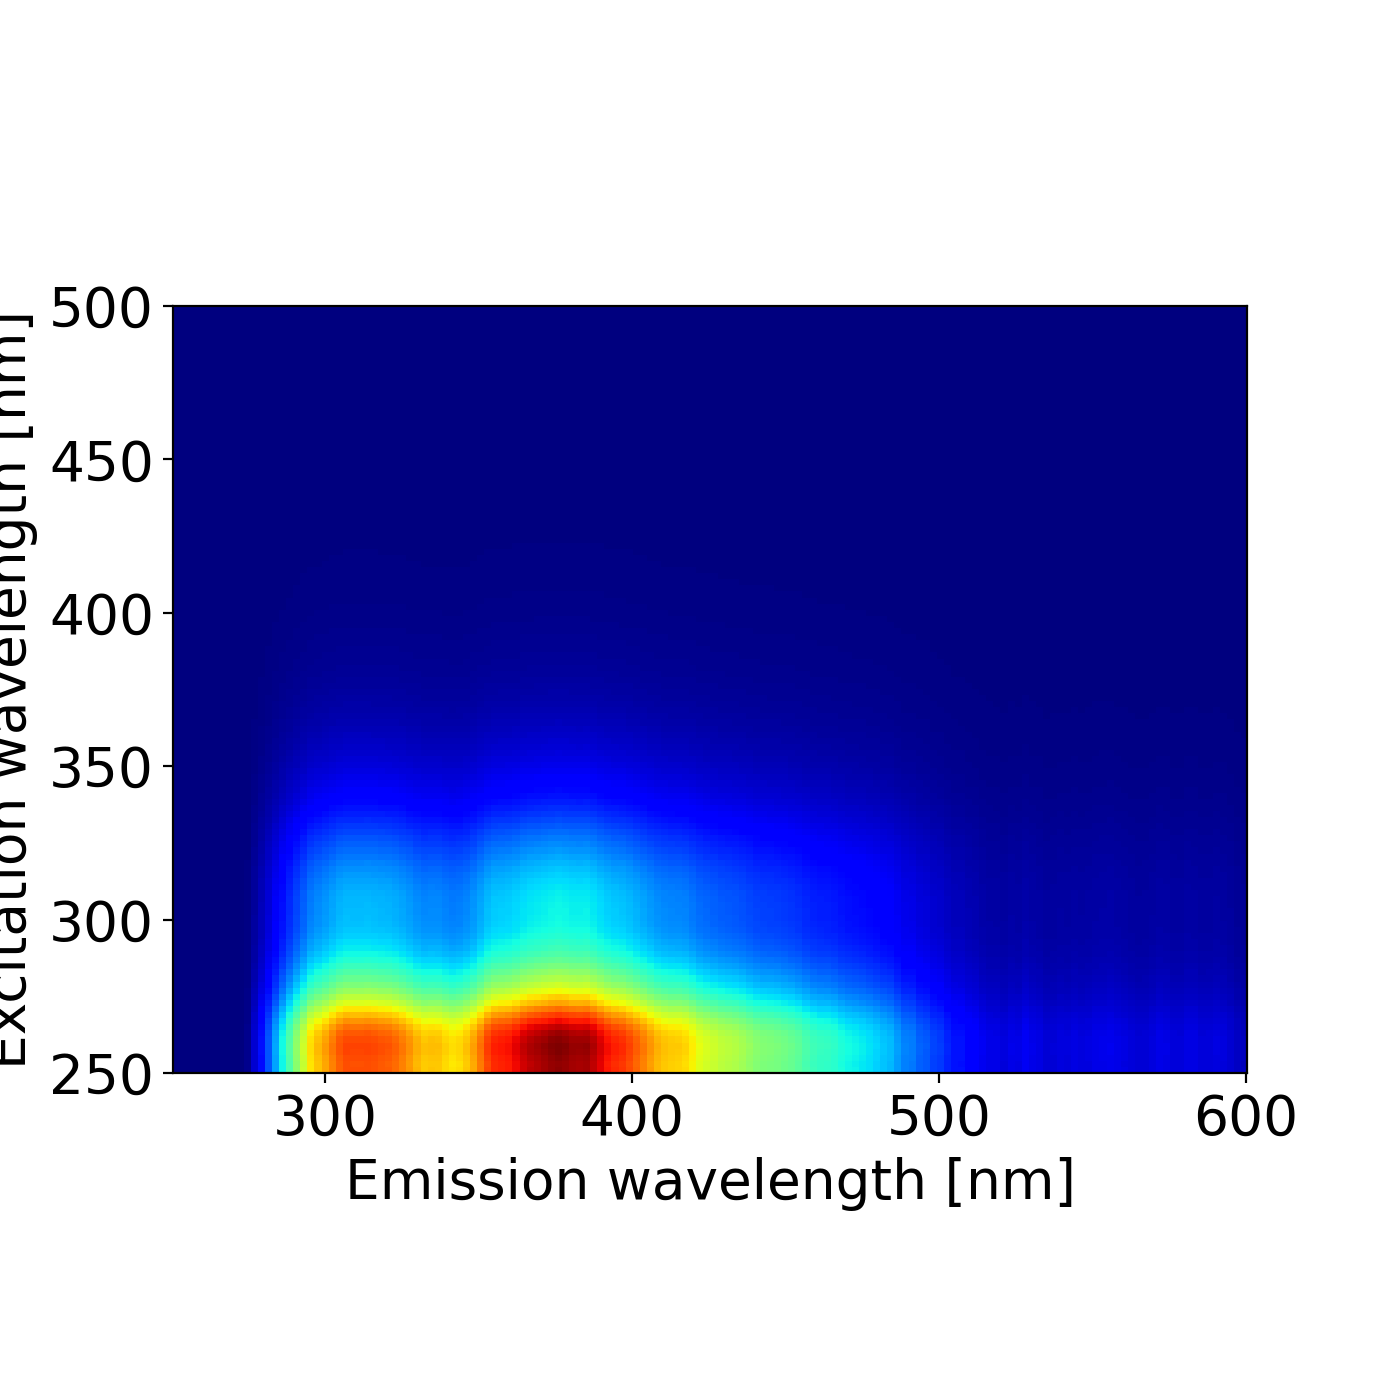

<IPython.core.display.Javascript object>


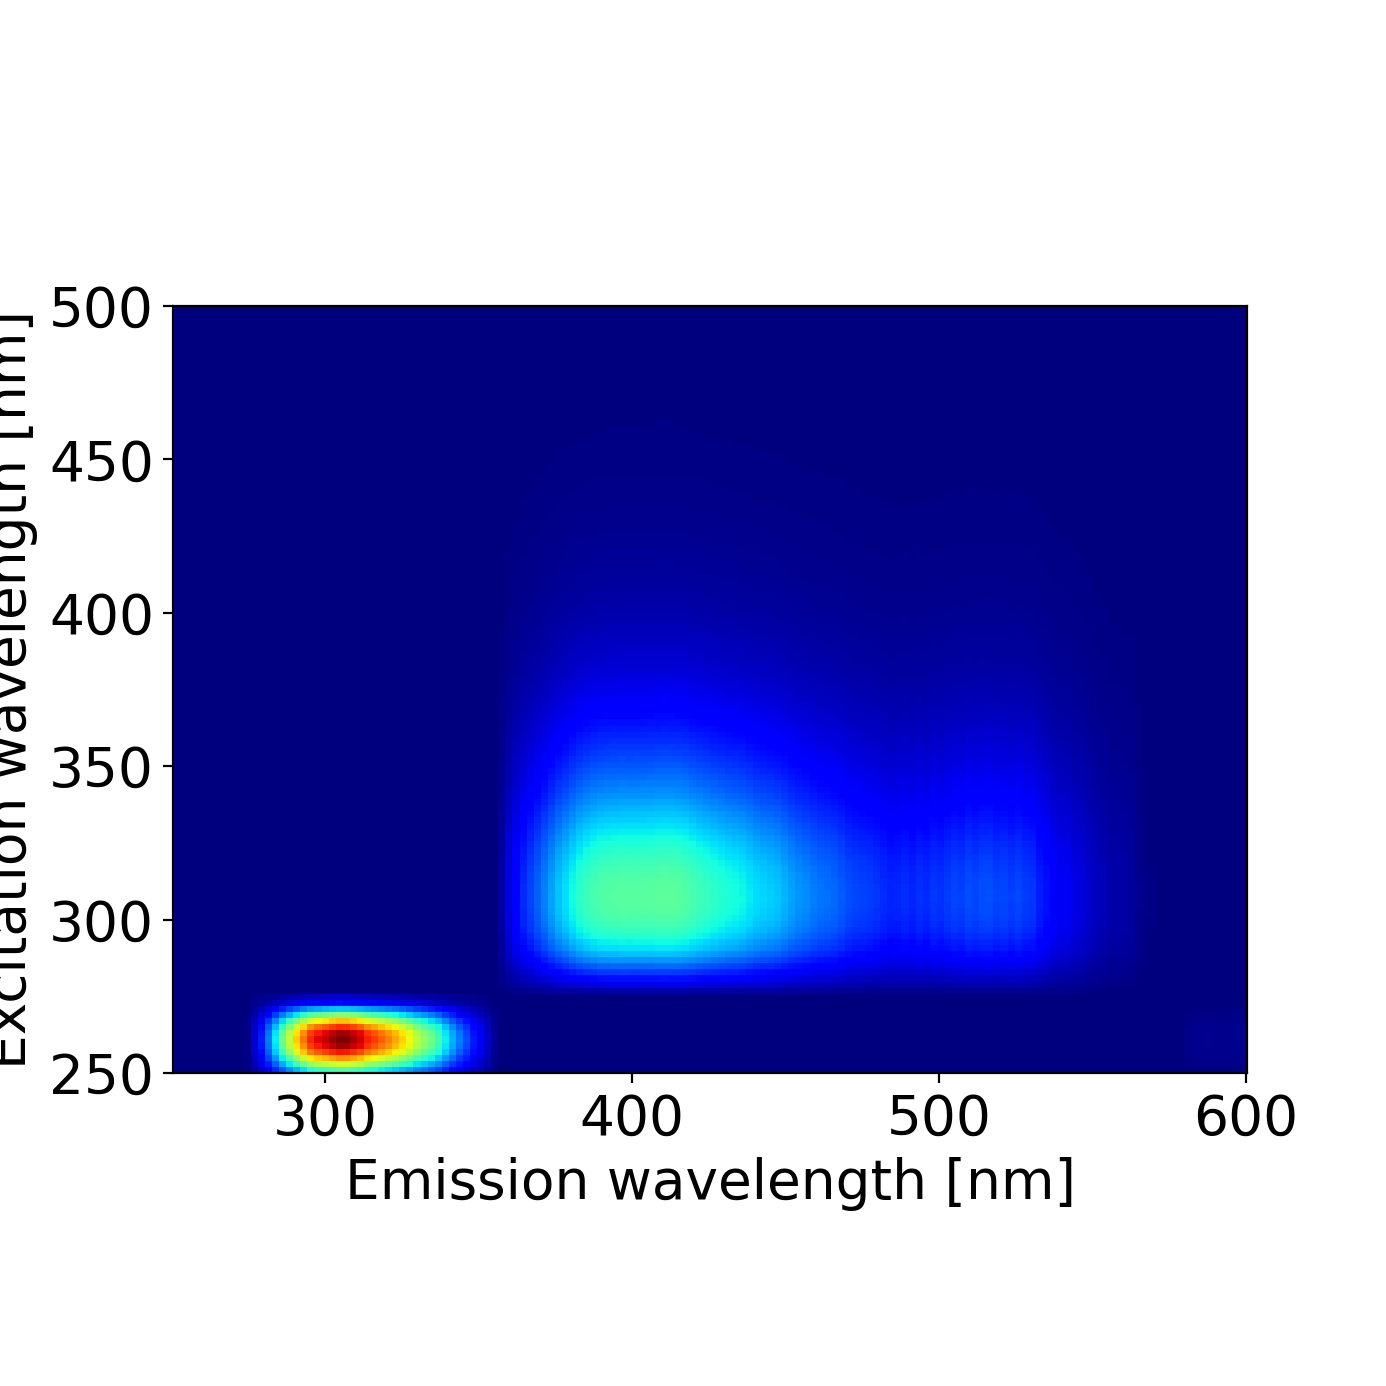

<IPython.core.display.Javascript object>


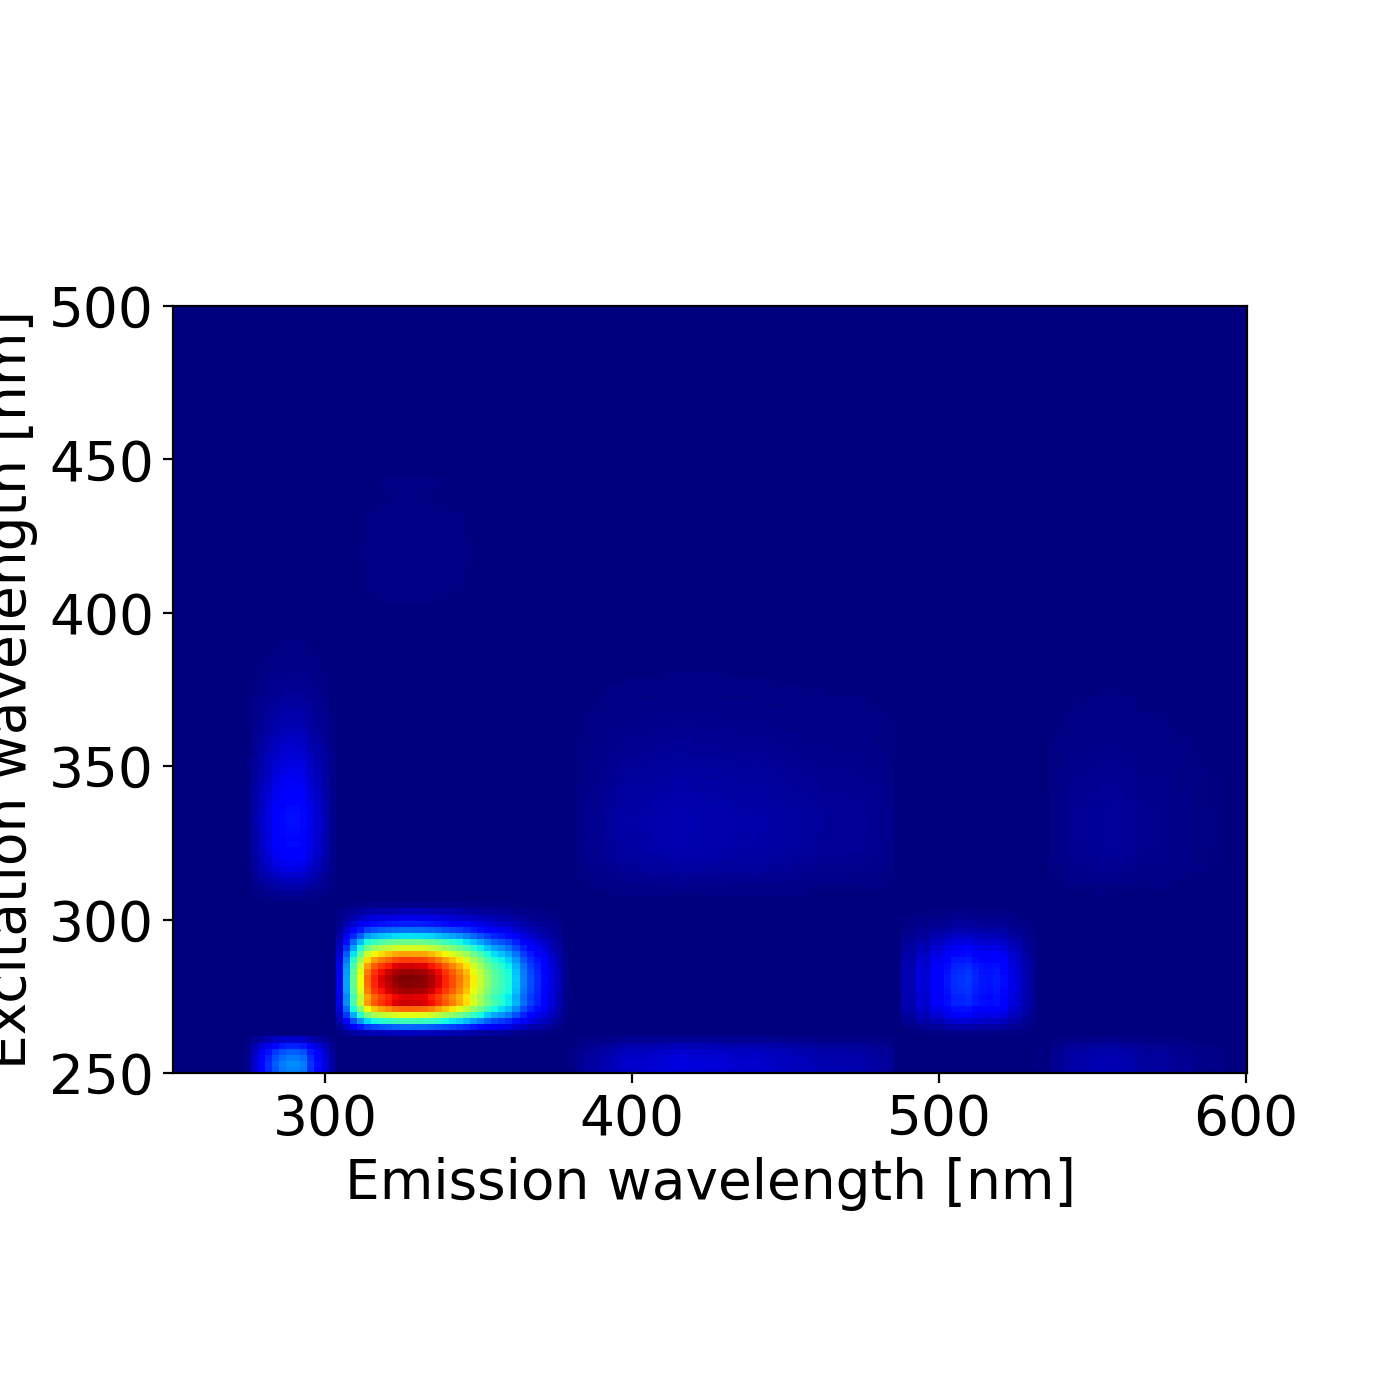

<IPython.core.display.Javascript object>


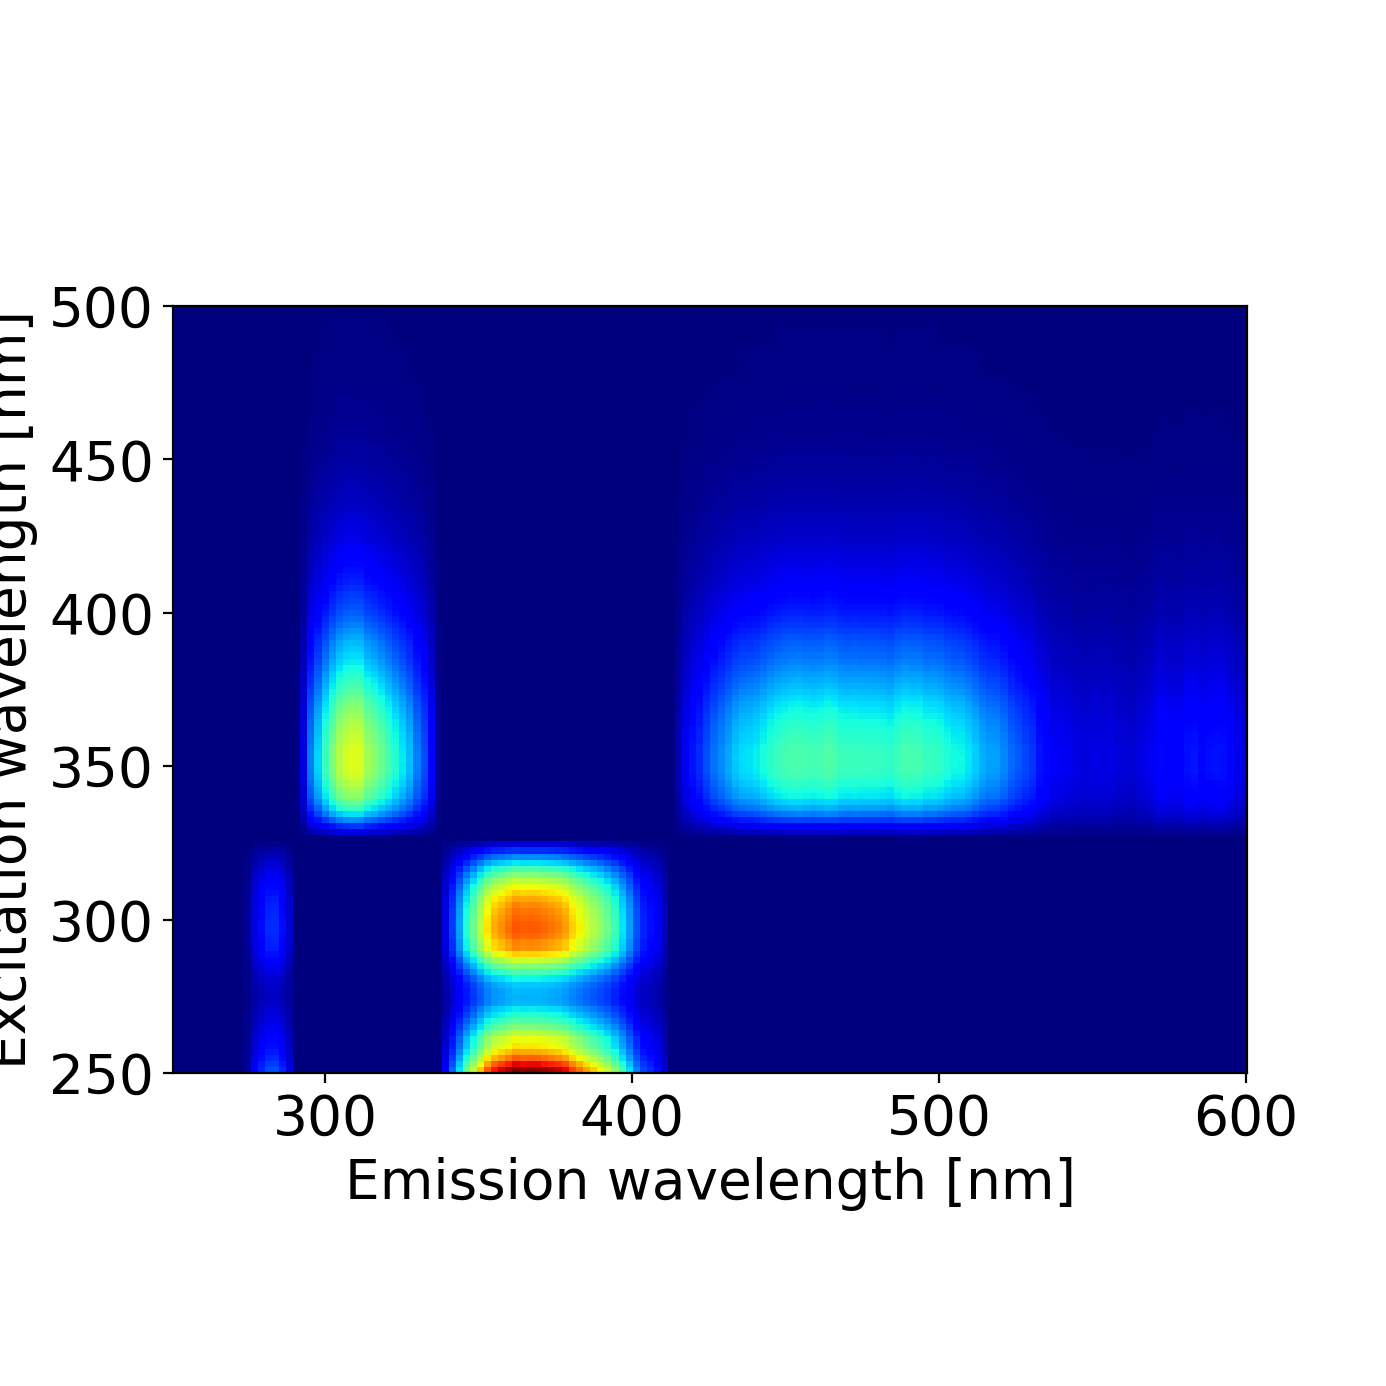

,component 1,component 2,component 3,component 4
2021-03-25 19:05:00,238.304855,67.056156,93.878318,20.168057
2021-03-25 19:37:00,239.624800,69.441736,94.552520,20.064210
2021-03-25 20:08:00,296.054771,86.249565,95.877581,31.513094
2021-03-25 20:39:00,326.864824,95.923313,94.572267,35.537267
2021-03-25 21:10:00,323.623608,93.346614,94.678966,33.746400
2021-03-25 21:41:00,306.954431,88.481268,89.508972,34.471018
2021-03-25 22:12:00,301.829606,85.587549,88.696480,34.536601
2021-03-25 22:43:00,299.594692,87.190947,90.033574,31.077775
2021-03-25 23:14:00,302.502365,86.859494,88.304189,35.170708


<IPython.core.display.Javascript object>


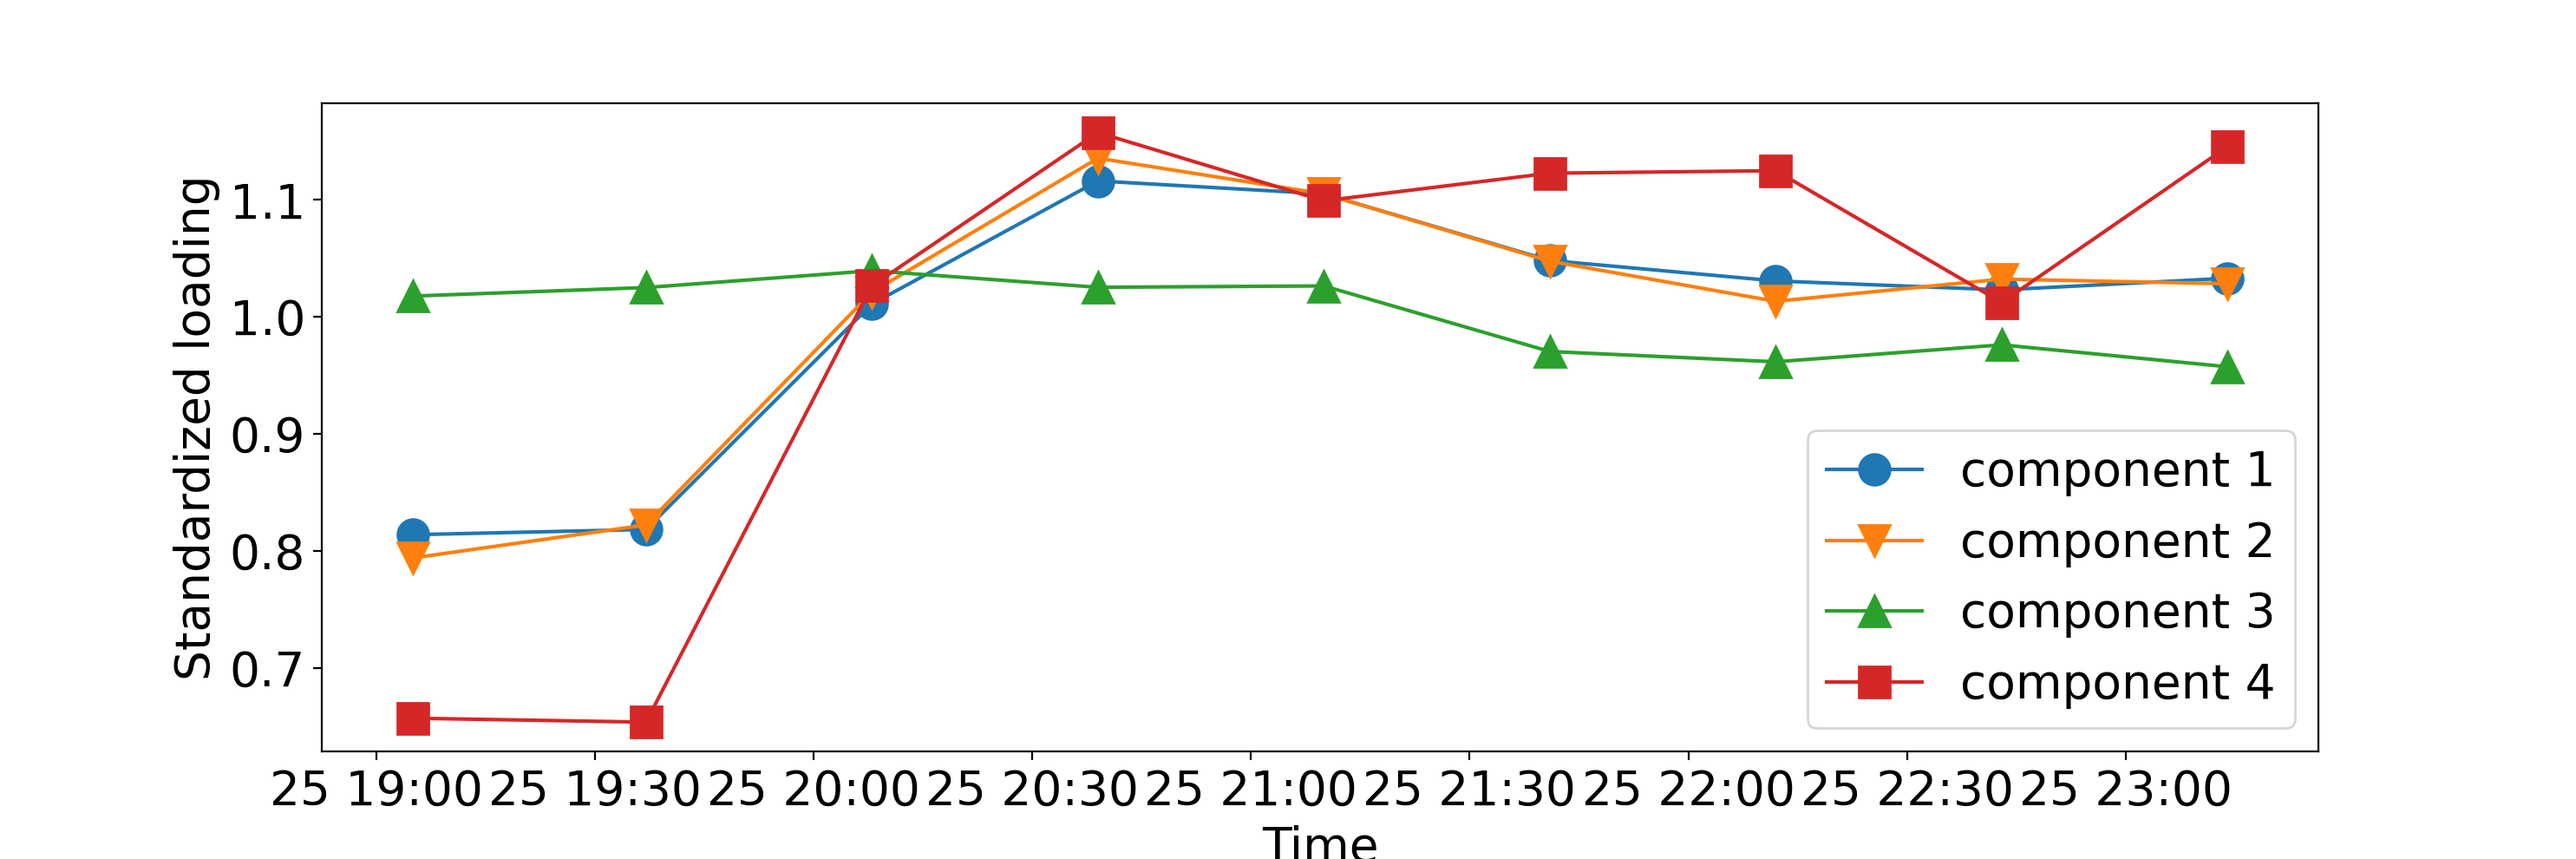

In [40]:
%matplotlib notebook
#--------------------Data stack analysis---------------
pd.set_option('display.max_rows', None)

# Are there any changes in the last step?
data_index_cw = []

if datlist_filtered==datlist_all:
    datlist_cw = datlist_all[:]
    EEMstack_cw = EEMstack_all[:,:,:]
else:
    datlist_cw = datlist_filtered[:]
    EEMstack_cw = np.delete(EEMstack_filtered, idx2remove, 0)
    
if ts_read_from_filename.value:
    timestamps_cw = [get_TS_from_filename(dat, ts_format.value, ts_start_position.value-1, ts_end_position.value)
                for dat in datlist_cw ]
    timestamps_cw_sortidx = np.argsort(timestamps_cw)
    timestamps_cw = [timestamps_cw[i] for i in timestamps_cw_sortidx]
    datlist_cw = [datlist_cw[i] for i in timestamps_cw_sortidx]
    EEMstack_cw = EEMstack_cw[timestamps_cw_sortidx]
else:
    data_index_cw = [file[:-4] for file in datlist_cw]

#---------------Create widgets------------------------
#----------------General widgets------------
out = ipywidgets.Output()
display(out)

button_clear_display=ipywidgets.Button(description='Clear display')
def clear_display_with_button(b):
    clear_output()
    display(tab)
button_clear_display.on_click(clear_display_with_button)

#-------Tab1: File range selection----------

range1 = ipywidgets.Dropdown(value=datlist_cw[0],
                             options=datlist_cw,
                             description='Start',
                             style={'description_width': 'initial'},
                            continuous_update=False)
range2 = ipywidgets.Dropdown(value=datlist_cw[-1],
                             options=datlist_cw,
                             description='End',
                             style={'description_width': 'initial'},
                            continuous_update=False)

data_range_items = [
    ipywidgets.Box([Label(value='Select the range of data for further analysis')]),
    ipywidgets.Box([range1, range2], layout=form_item_layout)
#    ipywidgets.Box([button_data_range])
]

data_range = Box(data_range_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='80%'
))


#-------Tab2: Pixel statistics------------------

property_pixel = ipywidgets.Dropdown(options=['Timeseries analysis', 'Correlation analysis'],
                                    description='Property')
em_pixel = ipywidgets.FloatText(value=400, description='Em [nm]')
ex_pixel = ipywidgets.FloatText(value=300, description='Ex [nm]')
caption_pixel_statistics = ipywidgets.Label(value='For correlation analysis, please specify the reference data with either \
                            a file path or a manual input')
checkbox_reference_filepath_pixel = ipywidgets.Checkbox(value=False)
reference_filepath_pixel = ipywidgets.Text(
                                    value='reference_example.txt',
                                    description='File path of input reference data',
                                    style={'description_width': 'initial'},
                                    layout=Layout(width='400%'))
checkbox_reference_mannual_input_pixel = ipywidgets.Checkbox(value=True)
reference_mannual_input_pixel = ipywidgets.Text(description='Type input reference data manually',
                                         style={'description_width': 'initial'},
                                         layout=Layout(width='400%'))

def update_manual_input_reference_checkbox_pixel(*args):
    checkbox_reference_mannual_input_pixel.value=not checkbox_reference_filepath_pixel.value
        
def update_filepath_reference_checkbox_pixel(*args):
    checkbox_reference_filepath_pixel.value=not checkbox_reference_mannual_input_pixel.value
        
checkbox_reference_filepath_pixel.observe(update_manual_input_reference_checkbox_pixel, 'value')
checkbox_reference_mannual_input_pixel.observe(update_filepath_reference_checkbox_pixel, 'value')
button_pixel_statistics = ipywidgets.Button(description='Calculate')

def pixel_statistics_interact(*args):
    %matplotlib notebook
    EEMstack_class_cw = EEMstack(EEMstack_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                         Em_range_cw, Ex_range_cw)
    if property_pixel.value =='Timeseries analysis':
        EEMstack_class_cw.pixel_rel_std(Em=em_pixel.value, Ex=ex_pixel.value, plot=True,
                                       timestamp=timestamps_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                                       baseline=False, output=True)
    if property_pixel.value =='Correlation analysis':
        if checkbox_reference_filepath_pixel.value:
            reference = read_reference_from_text(reference_filepath_pixel.value)
        if checkbox_reference_mannual_input_pixel.value:
            reference = string_to_float_list(reference_mannual_input_pixel.value)
        EEMstack_class_cw.pixel_linreg(Em=em_pixel.value, Ex=ex_pixel.value, x=reference)

button_pixel_statistics.on_click(pixel_statistics_interact)

pixel_statistics_items = [
    ipywidgets.Box([ex_pixel, em_pixel, property_pixel]),
    ipywidgets.Box([caption_pixel_statistics],layout=form_item_layout),
    ipywidgets.Box([checkbox_reference_filepath_pixel, reference_filepath_pixel],layout=form_item_layout),
    ipywidgets.Box([checkbox_reference_mannual_input_pixel, reference_mannual_input_pixel],layout=form_item_layout),
    ipywidgets.Box([button_pixel_statistics, button_clear_display]),
]

pixel_statistics = Box(pixel_statistics_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='100%'
))

#-------Tab3: EEM statistics---------

property_eem = ipywidgets.Dropdown(options=['Mean', 'Standard deviation', 'Relative standard deviation',
                                              'Correlation: Linearity', 'Correlation: Pearson coef.',
                                           'Correlation: Spearman coef.'],
                                    description='Property',style={'description_width': 'initial'})
caption_eem_statistics = ipywidgets.Label(value='For correlation analysis, please specify the reference data with either \
                            a file path or a manual input')
checkbox_reference_filepath_eem = ipywidgets.Checkbox(value=False)
reference_filepath_eem = ipywidgets.Text(
                                    value='reference_example.txt',
                                    description='File path of input reference data',
                                    style={'description_width': 'initial'},
                                    layout=Layout(width='400%'))
checkbox_reference_mannual_input_eem = ipywidgets.Checkbox(value=True)
reference_mannual_input_eem = ipywidgets.Text(description='Type input reference data manually',
                                         style={'description_width': 'initial'},
                                         layout=Layout(width='400%'))

def update_manual_input_reference_checkbox_eem(*args):
    checkbox_reference_mannual_input_eem.value=not checkbox_reference_filepath_eem.value

def update_filepath_reference_checkbox_eem(*args):
    checkbox_reference_filepath_eem.value=not checkbox_reference_mannual_input_eem.value
    
checkbox_reference_filepath_eem.observe(update_manual_input_reference_checkbox_eem, 'value')
checkbox_reference_mannual_input_eem.observe(update_filepath_reference_checkbox_eem, 'value')
button_eem_statistics = ipywidgets.Button(description='Calculate')
title_eem_statistics = ipywidgets.Checkbox(value=True, description='Title',
                                          style={'description_width': 'initial'})

def EEM_statistics_interact(*arg):
    EEMstack_class_cw = EEMstack(EEMstack_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                                 Em_range_cw, Ex_range_cw)
    reference = None
    header = None
    if property_eem.value=='Correlation: Linearity' or property_eem.value=='Correlation: Pearson coef.' or \
       property_eem.value=='Correlation: Spearman coef.':
        if checkbox_reference_filepath_eem.value:
            reference, header = read_reference_from_text(reference_filepath_eem.value)
        if checkbox_reference_mannual_input_eem.value:
            reference = string_to_float_list(reference_mannual_input_eem.value)
    EEM_statistics(EEMstack_class_cw, term=property_eem.value, title=title_eem_statistics.value,
                  reference=reference, crange=crange_cw.value, reference_label=header)

button_eem_statistics.on_click(EEM_statistics_interact)

eem_statistics_items = [
    ipywidgets.Box([property_eem]),
    ipywidgets.Box([caption_pixel_statistics],layout=form_item_layout),
    ipywidgets.Box([checkbox_reference_filepath_eem, reference_filepath_eem],layout=form_item_layout),
    ipywidgets.Box([checkbox_reference_mannual_input_eem, reference_mannual_input_eem],layout=form_item_layout),
    ipywidgets.Box([button_eem_statistics, button_clear_display]),
]

eem_statistics = Box(eem_statistics_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='100%'
))

#-------Tab4: Region integration------------

region_integration_items = [
    ipywidgets.Box([Label(value='Under construction')]),
    ipywidgets.Box([button_clear_display], layout=form_item_layout),
]

region_integration = Box(region_integration_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='60%'
))


#-------Tab5: Stack decomposition----------
rank_display = ipywidgets.IntText(value=4, description='Number of components',
                         style={'description_width': 'initial'})
button_decomposition_interact = ipywidgets.Button(description='Decompose',
                                           style={'description_width': 'initial'})
decomposition_method_list = ipywidgets.Dropdown(
                                                value='parafac',
                                                options=['parafac','non_negative_parafac', 'test_function'],
                                                style={'description_width': 'initial'},
                                                description='Decomposition method'
                                                )
show_normalized_score = ipywidgets.Checkbox(
                                            value=False,
                                            style={'description_width': 'initial'},
                                            description='Normalize the score by mean'
                                            )

show_nomalized_component = ipywidgets.Checkbox(
                                                value=False,
                                                style={'description_width': 'initial'},
                                                description='Normalize the component so that its maxima is equal to one',
                                                layout=Layout(width='100%')
                                                )

if not data_index:
    data_index_cw = timestamps_cw

def decomposition_interact_button(*arg):
    %matplotlib notebook
    decomposition_interact(EEMstack_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                         Em_range_cw, Ex_range_cw, rank_display.value, 
                         index=data_index_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                         decomposition_method=decomposition_method_list.value,
                          score_normalization=show_normalized_score.value,
                          component_normalization=show_nomalized_component.value, component_autoscale=False,
                          component_cmin=0, component_cmax=1, title=False, cbar=False)

button_decomposition_interact.on_click(decomposition_interact_button)


decomposition_items = [
    ipywidgets.Box([rank_display, decomposition_method_list, 
                    button_decomposition_interact, button_clear_display], layout=form_item_layout),
    ipywidgets.Box([Label(value='The number of components should be no more than the number of samples')]),
    show_nomalized_component, show_normalized_score
]

decomposition = Box(decomposition_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='100%'
))

#-------Tab6: Data reconstruction----------

data_to_view = ipywidgets.Dropdown(options=datlist_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                                  description='Select the data for reconstruction',
                                  style={'description_width': 'initial'},
                                  layout={'width':'max-content'})

button_decomposition_re_interact= ipywidgets.Button(description='Reconstruct',
                                           style={'description_width': 'initial'})

# In the future move the function to EEMprocessing.py

def decomposition_interact_re_button(*arg):
    if decomposition_method_list.value=='parafac':
        factors = parafac(EEMstack_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                         rank=rank_display.value)
    elif decomposition_method_list.value=='non_negative_parafac':
        factors = non_negative_parafac(EEMstack_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                         rank=rank_display.value)
    elif decomposition_method_list.value=='test_function':
            factors = non_negative_parafac(EEMstack_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                                           rank=rank_display.value, fixed_modes=[0,1], init="random")
    I_0 = factors[1][0]
    J_0 = factors[1][1]
    K_0 = factors[1][2]
    decomposition_reconstruction_interact(I_0, J_0, K_0, EEMstack_cw[datlist_cw.index(data_to_view.value)],
                                    Em_range_cw, Ex_range_cw,
                                    datlist_cw[datlist_cw.index(range1.value):datlist_cw.index(range2.value)+1],
                                   data_to_view.value, crange=crange_cw.value)

button_decomposition_re_interact.on_click(decomposition_interact_re_button)

decomposition_reconstruction_items = [
    ipywidgets.Box([Label(value='Please first specify the number of components and decomposition method \
                          in tab-5 "PARAFAC decomposition"')]),
    ipywidgets.Box([data_to_view, button_decomposition_re_interact, button_clear_display], layout=form_item_layout)
]

decomposition_reconstruction = Box(decomposition_reconstruction_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='80%'
))


tab = ipywidgets.Tab()
tab.children=[data_range, pixel_statistics, eem_statistics, region_integration,
              decomposition, decomposition_reconstruction]
tab.set_title(0, '1. Data range selection')
tab.set_title(1, '2. Pixel statistics')
tab.set_title(2, '3. EEM statistics')
tab.set_title(3, '4. Region integraion')
tab.set_title(4, '5. Stack decomposition')
tab.set_title(5, '6. Stack reconstruction')
display(tab)

# Test

C:\Users\YongminHu\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.020387726539835786
0.02636857613827791
0.25787277416668414
0.4177446004576305
0.5757797083270292
0.6108872237233436
0.4981631050786861
0.3352380048193568
0.37354133099629316
0.04029318596284022


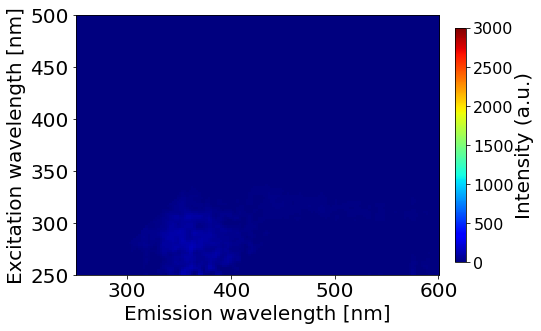

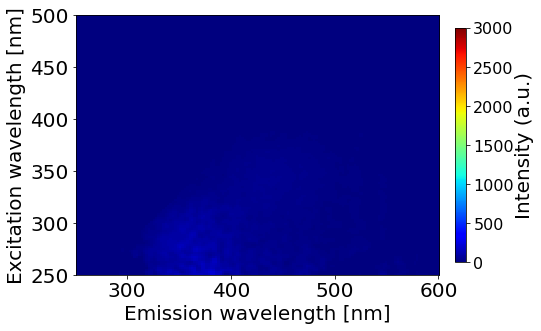

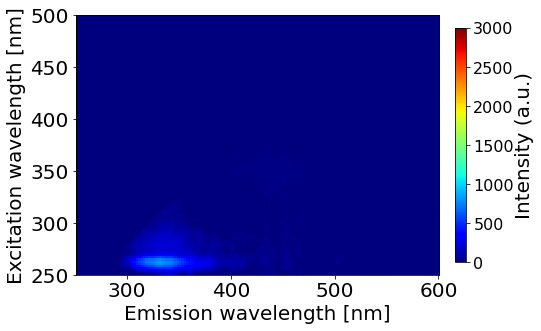

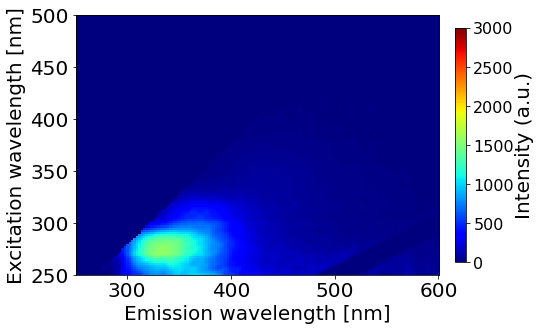

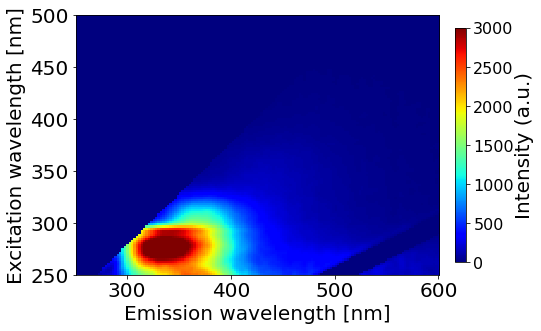

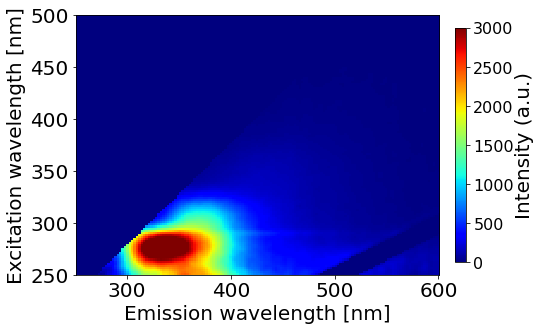

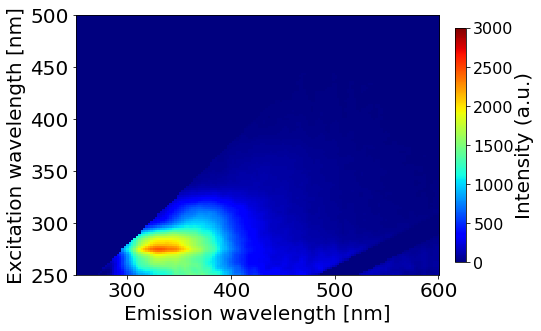

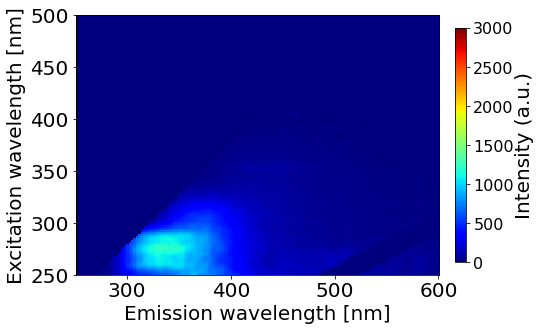

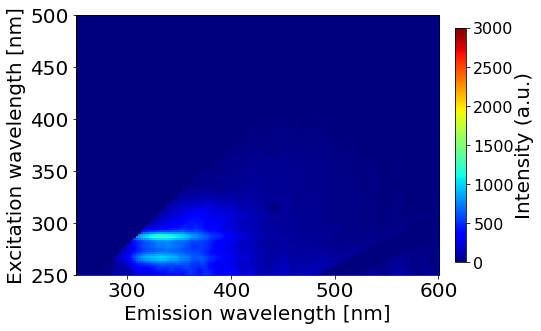

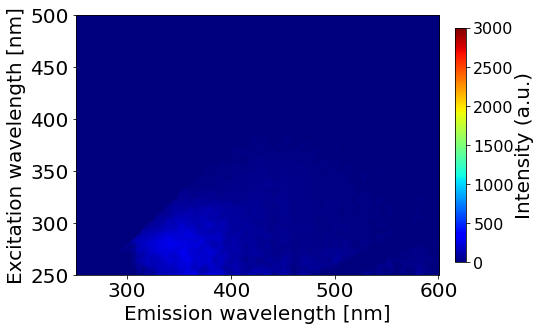

In [44]:
%matplotlib inline
reduction_avg = np.zeros(EEM_o_m2.shape[1:])
for i in range(EEM_o_m2.shape[0]):
    reduction = (EEM_o_m2[i,:,:]-EEM_f_m2[i,:,:])
    reduction_rate = reduction/EEM_o_m2[i,:,:]
    p = np.unravel_index(np.argmax(reduction, axis=None), reduction.shape)
    print(reduction_rate[p[0], p[1]])
#     print(Ex_range_cw[Ex_range_cw.shape[0] - p[0] - 1], Em_range_cw[p[1]])
    plot3DEEM(reduction, Em_range=Em_range_cw, Ex_range=Ex_range_cw, cmin=0, cmax=3000, autoscale=False)
#     reduction = EEM_o_m3[i,:,:]-EEM_f_m3[i,:,:]
#     plot3DEEM(reduction, Em_range=Em_range_cw, Ex_range=Ex_range_cw, autoscale=True)
    reduction_avg += reduction
reduction_avg = reduction_avg / EEM_o_m2.shape[0]
# reduction_avg[np.where(reduction_avg==0)]=np.nan
# plot3DEEM(reduction_avg, Em_range=Em_range_cw, Ex_range=Ex_range_cw, autoscale=False, cbar=True, cmin=-0.3, cmax=0.6)

In [10]:
factors = parafac(EEMstack_cw, rank=4)
I = factors[1][0]
J = factors[1][1]
K = factors[1][2]

<IPython.core.display.Javascript object>


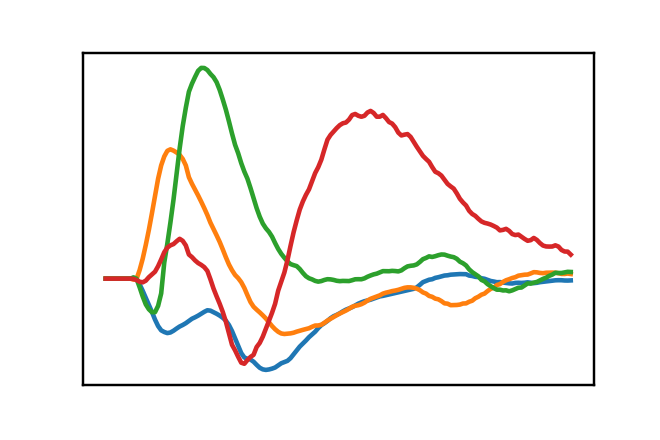

In [37]:
I_df = pd.DataFrame(K)
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(I_df)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [9]:
from sktensor import dtensor, cp_als
import numpy as np

def kronecker(matrices, tensor):
    K = len(matrices)
    x = tensor
    for k in range(K):
        M = matrices[k]
        x = x.ttm(M, k)
    return x

def corcondia(tensor, components = 1):
    k = components
    X = tensor
    X_approx_ks, fit, itr, exectimes = cp_als(X, k, init='random')
    
    A = X_approx_ks.U[0]
    B = X_approx_ks.U[1]
    C = X_approx_ks.U[2]

    x = X_approx_ks.totensor()

    Ua , Sa , Va = np.linalg.svd(A)
    Ub , Sb , Vb = np.linalg.svd(B)
    Uc , Sc , Vc = np.linalg.svd(C)

    SaI = np.zeros((Ua.shape[0],Va.shape[0]), float)
    np.fill_diagonal(SaI, Sa)

    SbI = np.zeros((Ub.shape[0],Vb.shape[0]), float)
    np.fill_diagonal(SbI, Sb)

    ScI = np.zeros((Uc.shape[0],Vc.shape[0]), float)
    np.fill_diagonal(ScI, Sc)

    SaI = np.linalg.pinv(SaI)
    SbI = np.linalg.pinv(SbI)
    ScI = np.linalg.pinv(ScI)

    y = kronecker([Ua.transpose(), Ub.transpose(), Uc.transpose()], x)
    z = kronecker([SaI, SbI, ScI], y)
    G = kronecker([Va.transpose(), Vb.transpose(), Vc.transpose()], z)
    
    # print G
    
    C = np.full((k, k, k), 0)
    for i in range(k):
        for j in range(k):
            for l in range(k):
                if i == j == l:
                    C[i][j][l] = 1
    
    c = 0
    for i in range(k):
        for j in range(k):
            for l in range(k):
                c += float(G[i][j][l] - C[i][j][l]) ** 2.0
    
    cc = 100 * (1 - (c / float(k)))
    
    return round(cc)

In [13]:
cc = corcondia(EEMstack_cw, components = 4)
print(cc)

ValueError: norm() object must be tensor (<class 'numpy.ndarray'>)